In [ ]:
# default_exp train.model

# Train 

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#export
import os

import numpy as np
import tensorflow as tf

In [ ]:
#hide
path_inputs = '../data/processed/input.npy'
path_targets = '../data/processed/target.npy'

In [ ]:
#hide
inputs = np.load(path_inputs)
targets = np.load(path_targets)

inputs.shape, targets.shape

((28, 100, 100, 7), (28, 100, 100, 1))

In [ ]:
#hide
targets_scaled = targets*1e4
targets_scaled.shape

(28, 100, 100, 1)

In [ ]:
#hide
inputs = inputs[:, :, :, :5]

In [ ]:
#hide
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets_scaled, test_size=0.2, random_state=1)

inputs_train.shape, inputs_test.shape

((22, 100, 100, 5), (6, 100, 100, 5))

In [ ]:
#export
class GoogleNetLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', autocast=False, **kwargs):
        super(GoogleNetLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[0], **default_params)
        self.conv2 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[1], **default_params)
        self.conv3 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        c2 = self.conv1(inputs)
        c3 = self.conv1(inputs)
        return self.concat([c1, c2, c3])

In [ ]:
#export
class GoogleNetTransposedLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', **kwargs):
        super(GoogleNetTransposedLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.convt1 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[0], **default_params)
        self.convt2 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[1], **default_params)
        self.convt3 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.convt1(inputs)
        c2 = self.convt1(inputs)
        c3 = self.convt1(inputs)
        return self.concat([c1, c2, c3])

In [ ]:
#export
class UnetModel(tf.keras.Model):
    def __init__(self, kernel_sizes):
        super(UnetModel, self).__init__()
        self.d1_layer = GoogleNetLayer(32, kernel_sizes, strides=(1,1), name='d1')
        self.d2_layer = GoogleNetLayer(64, kernel_sizes, strides=(2,2), name='d2')
        self.d3_layer = GoogleNetLayer(128, kernel_sizes, strides=(1,1), name='d3')
        self.d4_layer = GoogleNetLayer(256, kernel_sizes, strides=(2,2), name='d4')

        self.u4_layer = GoogleNetTransposedLayer(256, kernel_sizes, strides=(1,1), name='u4')
        self.u3_layer = GoogleNetTransposedLayer(128, kernel_sizes, strides=(2,2), name='u3')
        self.u2_layer = GoogleNetTransposedLayer(64, kernel_sizes, strides=(1,1), name='u2')
        self.u1_layer = GoogleNetTransposedLayer(32, kernel_sizes, strides=(2,2), name='u1')

        self.u0_layer = tf.keras.layers.Conv2D(1, (1,1), activation='linear', padding='same', name='u1')

        self.concat1 = tf.keras.layers.Concatenate()
        self.concat3 = tf.keras.layers.Concatenate()

    def call(self, inputs):
        d1 = self.d1_layer(inputs)
        d2 = self.d2_layer(d1)
        d3 = self.d3_layer(d2)
        d4 = self.d4_layer(d3)

        u4 = self.u4_layer(d4)
        u3 = self.u3_layer(u4)
        c3 = self.concat3([u3, d3])
        u2 = self.u2_layer(c3)
        u1 = self.u1_layer(u2)
        c1 = self.concat1([u1, d1])

        return self.u0_layer(c1)

In [ ]:
#hide
kernel_sizes = [(3,3), (5,5), (7,7)]

model = UnetModel(kernel_sizes)
model.build((None, 100, 100, 5))
model.summary()
# inputs_train.shape

Model: "unet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1 (GoogleNetLayer)          multiple                  1472      
_________________________________________________________________
d2 (GoogleNetLayer)          multiple                  55360     
_________________________________________________________________
d3 (GoogleNetLayer)          multiple                  221312    
_________________________________________________________________
d4 (GoogleNetLayer)          multiple                  884992    
_________________________________________________________________
u4 (GoogleNetTransposedLayer multiple                  1769728   
_________________________________________________________________
u3 (GoogleNetTransposedLayer multiple                  884864    
_________________________________________________________________
u2 (GoogleNetTransposedLayer multiple                  4

In [ ]:
#hide
optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

In [ ]:
#hide
tf.keras.backend.set_value(model.optimizer.lr, 1e-4)

In [ ]:
#hide
model.fit(
    inputs_train, 
    targets_train, 
    epochs=200,
    validation_data=(inputs_test, targets_test),
    validation_freq=5
)

Epoch 1/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0396
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0383
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0361
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0354
Epoch 5/200
1/1 [==============================] - 0s 153ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0365 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0716
Epoch 6/200
1/1 [==============================] - 0s 988us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0374
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0370
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0358
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022 -

KeyboardInterrupt: 

In [ ]:
#hide
model.save_weights('../models/model')

In [ ]:
#hide
%%time
preds_train = model.predict(inputs_train)
inputs_train.shape

Wall time: 711 ms


(22, 100, 100, 5)

In [ ]:
#hide
%%time
preds_test = model.predict(inputs_test)
preds_test.shape

Wall time: 121 ms


(6, 100, 100, 1)

In [ ]:
#export
def plot_example(target, pred):
    vmax = min(np.max(pred), np.max(target))
    vmin = min(np.min(pred), np.min(target))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    ax0.imshow(np.squeeze(pred), vmin=vmin, vmax=vmax)
    ax0.set_title('prediction')

    im = ax1.imshow(np.squeeze(target), vmin=vmin, vmax=vmax)
    ax1.set_title('target')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    # plt.colorbar();

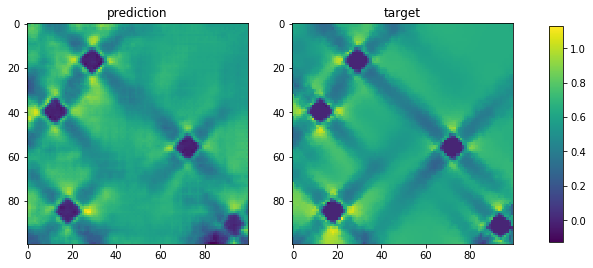

In [ ]:
#hide
idx = 2
plot_example(targets_test[idx], preds_test[idx])

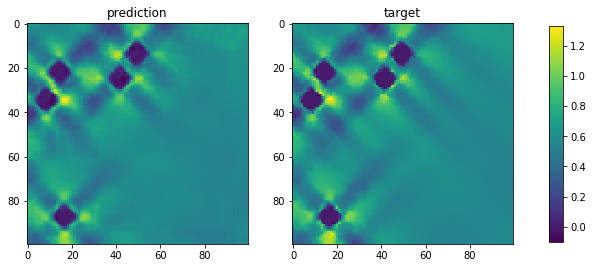

In [ ]:
#hide
idx = 15
plot_example(targets_train[idx], preds_train[idx])